In [1]:
# PyTorch package and submodules
import torch
import torch.nn as nn
from torch.optim import SGD #gradient descent optimizer

# NumPy for math operations, and Pandas for processing tabular data.
import numpy as np
import pandas as pd

# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

# Import matplotlib.pyplot to visualize tree models
import matplotlib.pyplot as plt

# Use imbalanced learn package
from imblearn.over_sampling import SMOTE

from genetic_selection import GeneticSelectionCV

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix


from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split as tts, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier as XGBC
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [2]:
# Draw matrix fig using seaborn
def matrix_fig(title,y,yp):
  cm = confusion_matrix(y, yp)
  mtfig = sns.heatmap (cm, annot=True, fmt="d",cmap="YlGnBu")
  mtfig.set_title(title)
  mtfig.set_ylabel('True 1abel')
  mtfig.set_xlabel('predicted label')

# Evaluation of models
def evaluation(title, y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  False_precision_score = cm[0, 0] / (cm[0, 0] + cm[1, 0]) # 负样本查准率（精准率）
  False_recall_score = cm[0, 0] / (cm[0, 0] + cm[0, 1]) #负样本查全率（召回率）
  False_fl_score = 2/(1/ False_precision_score + 1 / False_recall_score)
  print(title+"_Ture_precision_score:", round(metrics.precision_score(y_test, y_pred), 4))
  print(title+"_Ture_recall_score :", round(metrics.recall_score(y_test, y_pred) , 4))
  print(title+"_Ture_F1_score:", round(f1_score(y_test, y_pred) , 4))
  print(title+"_False_precision_score:", round(False_precision_score, 4))
  print(title+"_False_recall_score :", round(False_recall_score, 4))
  print(title+"_False_F1_score:", round(False_fl_score, 4))
  print(title+"accuracy_score",round(metrics.accuracy_score(y_test, y_pred) , 4))
  x = [u"Ture_precision_score",u"Ture_recall_score", u"Ture_F1_score",u"False_precision_score",u"False_recall_score",u"False_F1_score",u"accuracy_score"]
  y = [round(metrics.precision_score(y_test, y_pred), 4),
       round(metrics.recall_score(y_test, y_pred) , 4),
       round(f1_score(y_test, y_pred) , 4),
       round(False_precision_score, 4),
       round(False_recall_score, 4),
       round(False_fl_score, 4),
       round(metrics.accuracy_score(y_test, y_pred) , 4)]
  fig, ax = plt.subplots()
  ax.bar(x, y)
  ax.set_xticklabels(x, rotation=90)
  ax.set_xlabel('Param')
  ax.set_ylabel('Score')
  ax.set_title(title)
  for a,b in zip(x,y):
    plt.text(a,b +0.01, '%.3f' %b, ha='center', va = 'bottom', fontsize = 7)
  plt.show()

# Roc_Auc 
def roc_auc_fig(title, y_test, y_pred) :
  fpr,tpr,threshold = roc_curve(y_test, y_pred) #计算真正率和假正率
  roc_auc = auc(fpr,tpr)  ##计算auc的值
  plt.figure()
  lw = 2
  plt.figure(figsize=(5,4))
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area =%0.2f)' %roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0,1.05])
  plt.xlabel ( 'False Positive Rate' )
  plt.ylabel ( 'True Positive Rate' )
  plt.title (title+ 'Receiver operating characteristic example' )
  plt.legend (loc="lower right" )
  plt.show( )

# Import Data

In [3]:
df = pd.read_csv("/Users/Siqi/Desktop/SPH6004/Assignment_1_data.csv")
feature_columns = df.columns[~df.columns.isin(['outcome'])]
target_column = 'outcome'
df["outcome"] = df["outcome"].astype(int)
df['gender'] = df['gender'].replace({'F':0,'M':1})

for i in feature_columns:
  df[i] = pd.to_numeric(df[i])

#df.replace({'outcome': {'False': 0, 'True': 1}})
#df['gender'].replace(to_replace = 'M', value = 1, inplace = True)

df.head()
#df.info()
#df.shape

,gender,age,heart_rate_min,heart_rate_max,heart_rate_mean,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,...,bilirubin_indirect_min,urineoutput,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
0,1,54.550390,93.0,115.0,103.500000,57.0,100.0,82.733333,87.0,163.0,...,NaN,3459.0,2.0,0.0,NaN,1.0,0.0,1.0,3,0
1,1,86.324653,50.0,61.0,54.333333,61.0,93.0,71.695652,95.0,141.0,...,NaN,2020.0,NaN,1.0,NaN,1.0,1.0,1.0,8,0
2,1,40.270146,70.0,105.0,83.434783,66.0,92.0,76.695652,94.0,129.0,...,NaN,3050.0,NaN,1.0,0.0,1.0,1.0,0.0,4,0
3,1,73.383547,68.0,98.0,83.880000,74.0,101.0,84.694444,83.0,148.0,...,NaN,1592.0,NaN,0.0,NaN,0.0,0.0,1.0,6,0
4,1,70.724748,77.0,95.0,85.771429,30.0,90.0,62.657143,52.0,129.0,...,NaN,339.0,2.0,0.0,0.0,4.0,1.0,3.0,10,0


# Data pre-processing (missing data)

In [4]:
# Check the percentage of missing values
missing_perc = df.isnull().sum() / len(df)
missing_perc

gender                        0.000000
age                           0.000000
heart_rate_min                0.001973
heart_rate_max                0.001973
heart_rate_mean               0.001973
mbp_min                       0.002412
mbp_max                       0.002412
mbp_mean                      0.002412
sbp_min                       0.004001
sbp_max                       0.004001
sbp_mean                      0.004001
dbp_min                       0.004056
dbp_max                       0.004056
dbp_mean                      0.004056
temperature_min               0.009948
temperature_max               0.009948
temperature_mean              0.009948
lactate_min                   0.563430
lactate_max                   0.563430
ph_min                        0.483132
ph_max                        0.483132
chloride_min                  0.832032
chloride_max                  0.832032
calcium_min                   0.745430
calcium_max                   0.745430
sodium_min               

In [5]:
# Drop columns with missing values percentage geater than 0.5
missing_drop = missing_perc[missing_perc > 0.5].index.tolist()
print(missing_drop)
df.drop(missing_drop, axis=1, inplace=True)

['lactate_min', 'lactate_max', 'chloride_min', 'chloride_max', 'calcium_min', 'calcium_max', 'sodium_min', 'sodium_max', 'total_protein_max', 'total_protein_min', 'bilirubin_direct_max', 'bilirubin_direct_min', 'bilirubin_indirect_max', 'bilirubin_indirect_min', 'sofa_respiration']


In [6]:
df.shape

(36489, 45)

# Correlation 

In [7]:
# Check correlation
corr = df.corr().abs()
filt_matrix = corr[((corr >= 0.5) | (corr <= -0.5)) & (corr !=1.00)]
plt.figure(figsize=(36,36),dpi = 480)
sns.heatmap(filt_matrix, annot=True, cmap="Reds")
plt.show()

In [8]:
# Select upper triangle of correlation matrix
upper_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Drop features with correlation greater than 0.75
to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] >= 0.75)]
print(to_drop)
df.drop(to_drop, axis=1, inplace=True)

['heart_rate_mean', 'sbp_mean', 'dbp_min', 'dbp_mean', 'temperature_mean', 'wbc_max', 'creatinine_max', 'hemoglobin_max', 'pt_max', 'alt_min', 'alp_min', 'ast_min', 'ast_max', 'bilirubin_total_min']


/var/folders/qy/w7ktgxnx5svft6xymt5d8k1w0000gq/T/ipykernel_65483/1991014287.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


# SimpleImputer

In [9]:
imputer = SimpleImputer(strategy='mean')
df1 = df.copy()
df1 = pd.DataFrame(imputer.fit_transform(df1))
df1.columns = df.columns

In [10]:
df1.describe()

,gender,age,heart_rate_min,heart_rate_max,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,dbp_max,...,alp_max,bilirubin_total_max,urineoutput,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
count,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,...,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000,36489.000000
mean,0.544822,65.907162,70.935003,103.109572,60.429777,105.484634,79.255689,94.449898,147.691412,90.387455,...,124.666954,1.705939,1914.991284,0.481109,0.514094,1.060381,0.915433,0.826501,5.798104,0.036422
std,0.497994,16.797498,15.049239,20.662520,13.331243,23.318814,11.744512,16.671762,22.809577,20.142804,...,96.277540,2.926152,1242.062442,0.822158,0.687889,0.971351,1.050459,1.201148,3.014789,0.187340
min,0.000000,18.002527,9.000000,36.000000,0.830000,51.000000,42.513889,2.000000,49.000000,29.000000,...,7.000000,0.100000,-14850.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,55.549252,60.000000,88.000000,53.000000,91.000000,70.916667,84.000000,132.000000,76.000000,...,87.000000,0.600000,1080.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.000000
50%,1.000000,67.439033,70.000000,101.000000,60.000000,102.000000,77.884615,93.000000,146.000000,88.000000,...,124.666954,1.705939,1725.000000,0.000000,0.514094,1.000000,1.000000,0.000000,6.000000,0.000000
75%,1.000000,78.729524,80.000000,115.000000,68.000000,115.000000,86.360000,104.000000,161.000000,101.000000,...,124.666954,1.705939,2450.000000,1.000000,0.514094,1.000000,1.000000,1.000000,8.000000,0.000000
max,1.000000,102.865603,163.000000,295.000000,133.000000,299.000000,151.529412,184.000000,352.000000,273.000000,...,3358.000000,78.000000,31016.000000,4.000000,4.000000,4.000000,4.000000,4.000000,20.000000,1.000000


# Imbalance Data

In [11]:
X_raw = df1.iloc[:,:-1]
Y = df1.loc[:,['outcome']]

# Check data balance 
print("1:", len(Y[Y['outcome']==1]))
print("0:", len(Y[Y['outcome']==0]))

1: 1329
0: 35160


In [12]:
X = (X_raw-X_raw.mean())/X_raw.std()
X.describe()

,gender,age,heart_rate_min,heart_rate_max,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,dbp_max,...,alt_max,alp_max,bilirubin_total_max,urineoutput,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index
count,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,...,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04,3.648900e+04
mean,7.465443e-16,-3.137110e-14,-1.302401e-15,-3.623268e-15,3.881445e-15,-7.353067e-15,-7.778158e-15,-1.897486e-14,3.322138e-15,1.865859e-14,...,-3.124460e-14,1.643947e-13,1.016095e-13,2.953555e-14,2.200693e-15,4.560236e-14,-3.703603e-16,-5.755960e-16,-1.258064e-15,5.748429e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.094033e+00,-2.851891e+00,-4.115491e+00,-3.247889e+00,-4.470684e+00,-2.336510e+00,-3.128423e+00,-5.545299e+00,-4.326753e+00,-3.047612e+00,...,-2.153290e-01,-1.222164e+00,-5.488227e-01,-1.349770e+01,-5.851790e-01,-7.473496e-01,-1.091656e+00,-8.714598e-01,-6.880925e-01,-1.923221e+00
25%,-1.094033e+00,-6.166341e-01,-7.266150e-01,-7.312551e-01,-5.573207e-01,-6.211566e-01,-7.100357e-01,-6.268022e-01,-6.879309e-01,-7.142727e-01,...,-1.746469e-01,-3.912330e-01,-3.779498e-01,-6.722619e-01,-5.851790e-01,-7.473496e-01,-6.216216e-02,-8.714598e-01,-6.880925e-01,-5.964277e-01
50%,9.140240e-01,9.119642e-02,-6.212958e-02,-1.020966e-01,-3.223836e-02,-1.494345e-01,-1.167417e-01,-8.696728e-02,-7.415361e-02,-1.185264e-01,...,-3.227458e-14,1.638393e-13,1.023659e-13,-1.529644e-01,-5.851790e-01,4.583636e-14,-6.216216e-02,8.050509e-02,-6.880925e-01,6.696870e-02
75%,9.140240e-01,7.633495e-01,6.023559e-01,5.754587e-01,5.678557e-01,4.080553e-01,6.049047e-01,5.728310e-01,5.834649e-01,5.268653e-01,...,-3.227458e-14,1.638393e-13,1.023659e-13,4.307422e-01,6.311326e-01,4.583636e-14,-6.216216e-02,8.050509e-02,1.444446e-01,7.303651e-01
max,9.140240e-01,2.200235e+00,6.117585e+00,9.286884e+00,5.443620e+00,8.298680e+00,6.153829e+00,5.371364e+00,8.957141e+00,9.065895e+00,...,1.091894e+02,3.358346e+01,2.607317e+01,2.342959e+01,4.280068e+00,5.067541e+00,3.026319e+00,2.936400e+00,2.642056e+00,4.710744e+00


In [13]:
train_x, Xtest, train_y, Ytest = tts(df1.iloc[:, :-1], df1['outcome'], test_size=0.3, random_state=1)

In [14]:
train_y.value_counts()

0.0    24629
1.0      913
Name: outcome, dtype: int64

In [15]:
# Use SMOTE to resample minority class.
smote_sampler = SMOTE(random_state=12,sampling_strategy='minority')
Xtrain, Ytrain = smote_sampler.fit_resample(train_x, train_y)

In [16]:
Ytrain.value_counts()

0.0    24629
1.0    24629
Name: outcome, dtype: int64

# SVM

In [ ]:
# 'C': strength of L2 regularization on linear SVM. Larger 'C' --> smaller regularization.
parameters = {
    'C':np.arange(start=1,stop=20,step=5)
}
stratifiedCV = StratifiedKFold(n_splits=8)
SVCModel = SVC(kernel='linear')
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(Xtrain,Ytrain)

In [ ]:
BestSVC.fit(Xtrain,Ytrain)
BestSVC.best_estimator_
BestSVC.best_score_

#SVC(C = 6, kernel='linear')

In [ ]:
svm_2 = SVC(kernel='linear', C = 6)
svm_2.fit(Xtrain, Ytrain)

In [ ]:
# Predicting on the test set
pred_y = svm_2.predict(Xtest)
print ('AUC: %.4f' %metrics.roc_auc_score (Ytest, pred_y))
print ('ACC: %.4f' %metrics.accuracy_score (Ytest, pred_y))
print ('Recall: %.4f' %metrics.recall_score (Ytest, pred_y))
print ('F1-score: %.4f' %f1_score(Ytest, pred_y))
print ('Precision: %.4f' %metrics.precision_score(Ytest, pred_y))

from sklearn.metrics import classification_report
print(classification_report(Ytest, pred_y))
print (metrics.confusion_matrix(Ytest, pred_y))

roc_auc_fig('SVM',Ytest,pred_y)
evaluation ('SVM', Ytest,pred_y)
matrix_fig('SVM' ,Ytest,pred_y)

In [17]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(Xtrain, Ytrain)

SVC(probability=True)

In [18]:
# Predicting on the test set
ypred = svm.predict(Xtest)

AUC: 0.5871
ACC: 0.5365
Recall: 0.6418
F1-score: 0.0952
Precision: 0.0514
              precision    recall  f1-score   support

         0.0       0.97      0.53      0.69     10531
         1.0       0.05      0.64      0.10       416

    accuracy                           0.54     10947
   macro avg       0.51      0.59      0.39     10947
weighted avg       0.94      0.54      0.67     10947

[[5606 4925]
 [ 149  267]]


<Figure size 640x480 with 0 Axes>

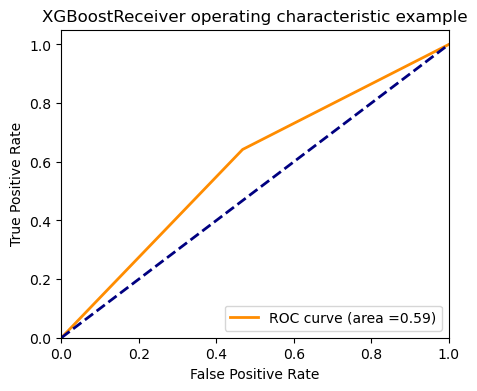

XGBoost_Ture_precision_score: 0.0514
XGBoost_Ture_recall_score : 0.6418
XGBoost_Ture_F1_score: 0.0952
XGBoost_False_precision_score: 0.9741
XGBoost_False_recall_score : 0.5323
XGBoost_False_F1_score: 0.6884
XGBoostaccuracy_score 0.5365


/var/folders/qy/w7ktgxnx5svft6xymt5d8k1w0000gq/T/ipykernel_65483/232486107.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)


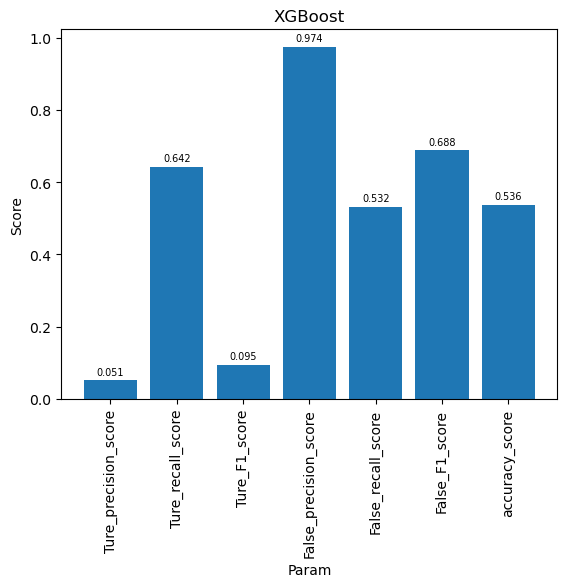

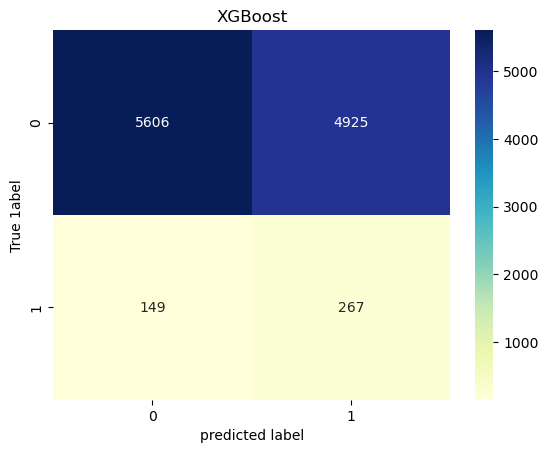

In [19]:
print ('AUC: %.4f' %metrics.roc_auc_score (Ytest, ypred))
print ('ACC: %.4f' %metrics.accuracy_score (Ytest, ypred))
print ('Recall: %.4f' %metrics.recall_score (Ytest, ypred))
print ('F1-score: %.4f' %f1_score(Ytest, ypred))
print ('Precision: %.4f' %metrics.precision_score(Ytest, ypred))

from sklearn.metrics import classification_report
print(classification_report(Ytest, ypred))
print (metrics.confusion_matrix(Ytest, ypred))

roc_auc_fig('SVM',Ytest,ypred)
evaluation ('SVM', Ytest,ypred)
matrix_fig('SVM' ,Ytest,ypred)

In [20]:
svm_1 = SVC(kernel='poly', class_weight='balanced', C = 0.001)
svm_1.fit(Xtrain, Ytrain)

SVC(C=0.001, class_weight='balanced', kernel='poly')

AUC: 0.5135
ACC: 0.0795
Recall: 0.9832
F1-score: 0.0751
Precision: 0.0390
              precision    recall  f1-score   support

         0.0       0.99      0.04      0.08     10531
         1.0       0.04      0.98      0.08       416

    accuracy                           0.08     10947
   macro avg       0.51      0.51      0.08     10947
weighted avg       0.95      0.08      0.08     10947

[[  461 10070]
 [    7   409]]


<Figure size 640x480 with 0 Axes>

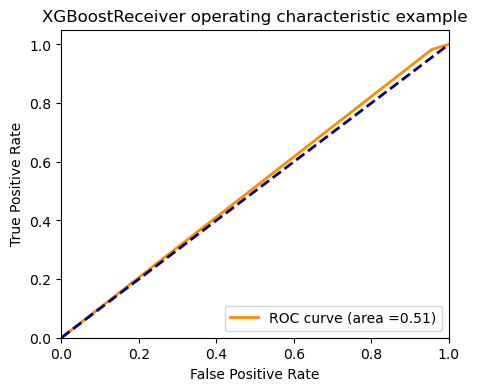

XGBoost_Ture_precision_score: 0.039
XGBoost_Ture_recall_score : 0.9832
XGBoost_Ture_F1_score: 0.0751
XGBoost_False_precision_score: 0.985
XGBoost_False_recall_score : 0.0438
XGBoost_False_F1_score: 0.0838
XGBoostaccuracy_score 0.0795


/var/folders/qy/w7ktgxnx5svft6xymt5d8k1w0000gq/T/ipykernel_65483/232486107.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)


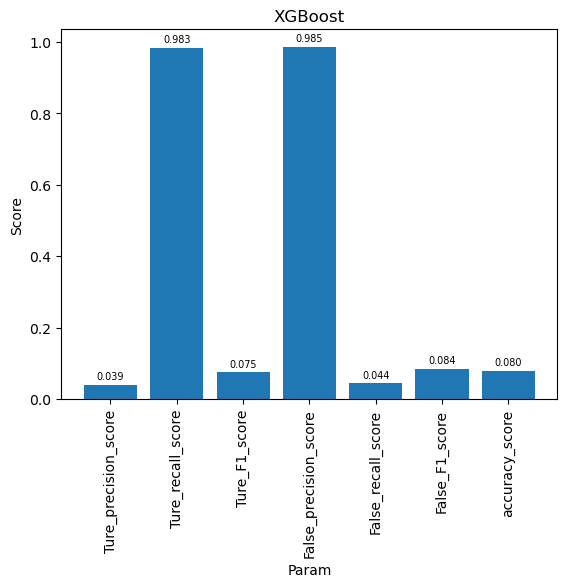

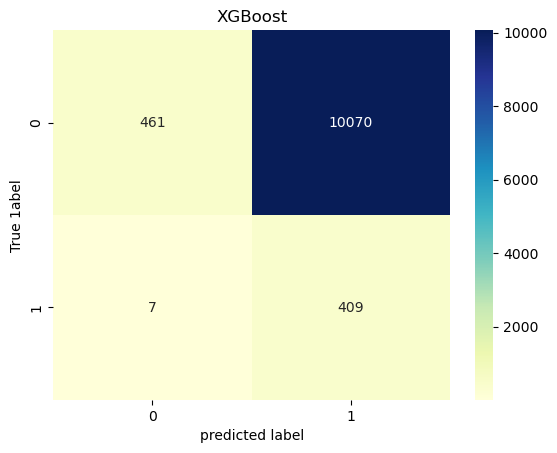

In [22]:
# Predicting on the test set
y_pred = svm_1.predict(Xtest)
print ('AUC: %.4f' %metrics.roc_auc_score (Ytest, y_pred))
print ('ACC: %.4f' %metrics.accuracy_score (Ytest, y_pred))
print ('Recall: %.4f' %metrics.recall_score (Ytest, y_pred))
print ('F1-score: %.4f' %f1_score(Ytest, y_pred))
print ('Precision: %.4f' %metrics.precision_score(Ytest, y_pred))

from sklearn.metrics import classification_report
print(classification_report(Ytest, y_pred))
print (metrics.confusion_matrix(Ytest, y_pred))

roc_auc_fig('XGBoost',Ytest,y_pred)
evaluation ('XGBoost', Ytest,y_pred)
matrix_fig('XGBoost' ,Ytest,y_pred)